In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from bs4 import BeautifulSoup
from selenium import webdriver
import QuantLib as ql
options = webdriver.ChromeOptions()
options.add_argument('headless')

In [4]:
def GET_DATE():
    driver = webdriver.Chrome('C:\it\python_workspace\chromedriver', options=options)
    driver.get("https://www.wsj.com/market-data/bonds")
    html = driver.page_source    
    soup = BeautifulSoup(html, 'html.parser')
    data = soup.find("span", class_="WSJBase--card__timestamp--3F2HxyAE")
    date = data.text
    date = date.split(' ')[3]
    date = datetime.datetime.strptime(date, "%m/%d/%y").date()
    return date

In [5]:
def GET_QUOTE(reference_date):
    driver = webdriver.Chrome('C:\it\python_workspace\chromedriver', options=options)
    tenors = ['01M', '03M', '06M', '01Y', '02Y', '03Y', '05Y', '07Y', '10Y', '30Y']
    
    # Create Empty Lists
    maturities = []
    days = []
    prices = []
    coupons = []
    
    # Get Market Information    
    for i, tenor in enumerate(tenors):
        driver.get("https://quotes.wsj.com/bond/BX/TMUBMUSD" + tenor + "?mod=md_bond_overview_quote")
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        
        # Price
        if i <= 3:
            data_src = soup.find("span", id="quote_val")
            price = data_src.text
            price = float(price[:-1])
        else:
            data_src = soup.find("span", id="price_quote_val")
            price = data_src.text
            price = price.split()
            price1 = float(price[0])
            price = price[1].split('/')
            price2 = float(price[0])
            price3 = float(price[1])            
            price = price1 + (price2 / price3)  
            
        data_src2 = soup.find_all("span", class_="data_data")
         # Coupon
        coupon = data_src2[2].text
        if coupon != '':
            coupon = float(coupon[:-1])
        else:
            coupon = 0.0
        
        # Maturity Date
        maturity = data_src2[3].text
        maturity = datetime.datetime.strptime(maturity, '%m/%d/%y').date()
        
        # Send to Lists
        days.append((maturity - reference_date).days)
        prices.append(price)
        coupons.append(coupon)
        maturities.append(maturity)
    
    # Create DataFrame
    df = pd.DataFrame([maturities, days, prices, coupons]).transpose()
    headers = ['maturity', 'days', 'price', 'coupon']
    df.columns = headers
    df.set_index('maturity', inplace=True)
    
    return df

In [6]:
ref_date = GET_DATE()
quote = GET_QUOTE(ref_date)
print(quote)

             days    price coupon
maturity                         
2021-05-25     32     0.01      0
2021-07-22     90    0.018      0
2021-10-21    181    0.038      0
2022-04-21    363    0.055      0
2023-03-31    707  99.3125  0.125
2024-04-15   1088  100.031  0.375
2026-03-31   1803  99.2188   0.75
2028-03-31   2534      100   1.25
2031-02-15   3585       96  1.125
2051-02-15  10890  92.0625  1.875


In [8]:
def TREASURY_CURVE(date, quote):
    
    # Divide Quotes
    tbill = quote[0:4]
    tbond = quote[4:]
    # 평가일 설정
    eval_date = ql.Date(date.day, date.month, date.year)
    ql.Settings.instance().evaluationDate = eval_date
    # 마켓 컨벤션 설정 #달력,금리설정일,이자계산방식,정산일자선정방식,명목금액,이자정산주기
    calendar = ql.UnitedStates()
    convention = ql.ModifiedFollowing
    day_counter = ql.ActualActual()
    end_of_month = True
    fixing_days = 1
    face_amount = 100
    coupon_frequency = ql.Period(ql.Semiannual)
    #Deposit Rate Helper
    #DepositRateHelper-무이표채에적용,
    #FixedRateBondHelper-이표채에적용
    bill_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                                        ql.Period(m, ql.Days),
                                        fixing_days,
                                        calendar,
                                        convention,
                                        end_of_month,
                                        day_counter)
                   for r, m in zip(tbill['price'], tbill['days'])]
                #for 문으로 무이표채 금리와 잔존일수 데이터 입력
    # Construct Treasury Bond Helpers [ Fixed Bond Rate Helper ]
    bond_helpers = []
    for p, c, m in zip(tbond['price'], tbond['coupon'], tbond['days']):
        termination_date = eval_date + ql.Period(m, ql.Days)
        schedule = ql.Schedule(eval_date,
                              termination_date,
                              coupon_frequency,
                              calendar,
                              convention,
                              convention,
                              ql.DateGeneration.Backward,
                              end_of_month)
        bond_helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(p)),
                                            fixing_days,
                                             face_amount,
                                             schedule,
                                             [c/100.0],
                                             day_counter,
                                             convention)
        bond_helpers.append(bond_helper)
        # FixedRateBondHelper - 이표채 이자지급스케쥴 생성
    # 헬퍼 결합(무이표채 + 이표채)
    rate_helper = bill_helpers + bond_helpers
    # 헬퍼를 커브 모듈에 태우기
    yc_linearzero = ql.PiecewiseLinearZero(eval_date, rate_helper, day_counter)
    return yc_linearzero

In [11]:
def DISCOUNT_FACTOR(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    return curve.discount(date)
# 특정일을 알려주면 할인계수 얼마인지 * 날짜를 퀀트립의 날짜 형식에 맞춰주기

In [9]:
def ZERO_RATE(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    day_counter = ql.ActualActual()
    compounding = ql.Compounded
    freq = ql.Continuous
    zero_rate = curve.zeroRate(date, day_counter, compounding, freq).rate()
    return zero_rate

# 특정 날짜의 제로금리가 얼마인지

            discount factor  zero rate
maturity                              
2021-05-25         0.999991   0.000100
2021-07-22         0.999966   0.000140
2021-10-21         0.999875   0.000252
2022-04-21         0.999563   0.000440
2023-03-31         0.990733   0.004812
2024-04-15         0.989228   0.003638
2026-03-31         0.955869   0.009163
2028-03-31         0.916147   0.012661
2031-02-15         0.855973   0.015905
2051-02-15         0.495138   0.023714


Text(0, 0.5, 'Discount Factor')

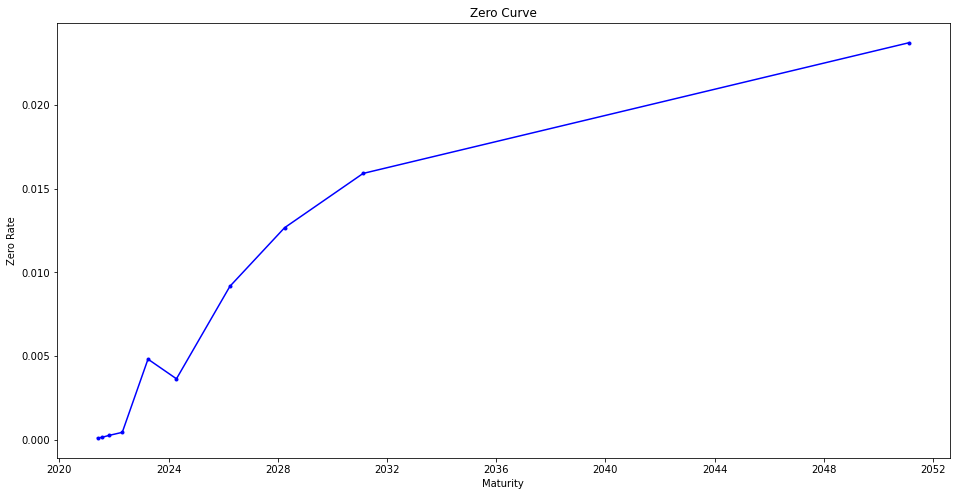

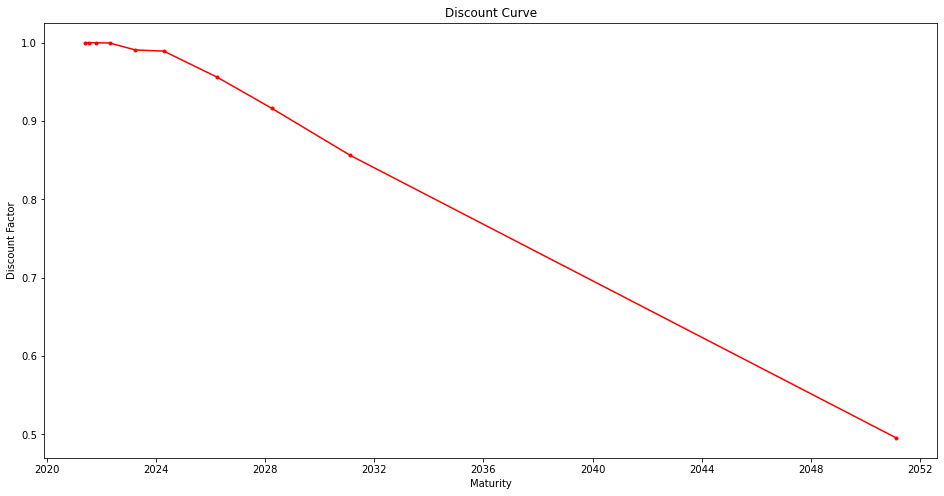

In [12]:
ref_date = GET_DATE()
quote = GET_QUOTE(ref_date)
curve = TREASURY_CURVE(ref_date, quote)

quote['discount factor'] = np.nan
quote['zero rate'] = np.nan

for date in quote.index:
    quote.loc[date, 'discount factor'] = DISCOUNT_FACTOR(date, curve)
    quote.loc[date, 'zero rate'] = ZERO_RATE(date, curve)
    
print(quote[['discount factor', 'zero rate']])

plt.figure(figsize=(16,8))
plt.plot(quote['zero rate'], 'b.-')
plt.title('Zero Curve', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Zero Rate')

plt.figure(figsize=(16,8))
plt.plot(quote['discount factor'], 'r.-')
plt.title('Discount Curve', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Discount Factor')

---------------------------------------------

In [13]:
# Counvert into Engine ( 프라이싱 엔진 객체로 변환 )

spotCurveHandle = ql.YieldTermStructureHandle(curve) # 핸들화 시킨 객체
bondEngine = ql.DiscountingBondEngine(spotCurveHandle) # 채권평가

YieldTermStucture() -> YieldTermStructureHandle() -> DiscountingBondEngine

# 상품 만들기

In [15]:
# Treasury Bond Specification

issueDate = ql.Date(15, 11, 2019)
maturityDate = ql.Date(15, 11, 2029)
tenor = ql.Period(ql.Semiannual)
calendar = ql.UnitedStates()
convention = ql.ModifiedFollowing
dateGeneration = ql.DateGeneration.Backward
monthEnd = False
schedule = ql.Schedule(issueDate,
                      maturityDate,
                      tenor,
                      calendar,
                      convention,
                      convention,
                      dateGeneration,
                      monthEnd)
dayCount = ql.ActualActual()
couponRate = [0.0175] # 쿠폰금리
settlementDays = 1    # 결제일 보통 1일후, 2일후
faceValue = 100       # 액면금액

fixedRateBond = ql.FixedRateBond(settlementDays, faceValue, schedule, couponRate, dayCount)

# 상품을 커브에 태우기

In [16]:
fixedRateBond.setPricingEngine(bondEngine)

In [19]:
# Result

print("Bond Pirce = {}".format(round(fixedRateBond.NPV(), 4)))

# 만기까지 현금흐름
for c in fixedRateBond.cashflows():
    print('%20s %12f' % (c.date(), c.amount()))

Bond Pirce = 103.4433
      May 15th, 2020     0.870834
 November 16th, 2020     0.884563
      May 17th, 2021     0.872000
 November 15th, 2021     0.872603
      May 16th, 2022     0.872603
 November 15th, 2022     0.877397
      May 15th, 2023     0.867808
 November 15th, 2023     0.882192
      May 15th, 2024     0.870834
 November 15th, 2024     0.879781
      May 15th, 2025     0.867193
 November 17th, 2025     0.891781
      May 15th, 2026     0.858219
 November 16th, 2026     0.886986
      May 17th, 2027     0.872603
 November 15th, 2027     0.872603
      May 15th, 2028     0.870834
 November 15th, 2028     0.879781
      May 15th, 2029     0.867193
 November 15th, 2029     0.882192
 November 15th, 2029   100.000000
